In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import datetime
from datetime import date
import yfinance as yf
from matplotlib import pyplot as plt
import keras
from keras.initializers import HeUniform
from keras.layers import Input, Dense
from keras.losses import Huber
from keras.optimizers import Adam
from keras.models import Sequential, Model
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from pickle import dump, load
import numpy as np
import random
from collections import deque
from IPython.display import clear_output
import os

In [ ]:
# Access GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 20 05:17:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_dir = f"{os.sep}content{os.sep}drive{os.sep}My Drive{os.sep}S&P 500 Stock Trading{os.sep}"

In [ ]:
ls "/content/drive/My Drive/S&P 500 Stock Trading/"

model_1/  model_3/  normalizer_x.pkl  x.npy       x_train.npy  y.npy       y_train.npy
model_2/  model_4/  normalizer_y.pkl  x_test.npy  x_val.npy    y_test.npy  y_val.npy


# Get S&P 500 Stock Data

In [ ]:
class Company:
  def __init__(self, symbol, name, stock):
    self.symbol = symbol
    self.name = name
    self.stock = stock

In [ ]:
symbols = []
names = []

In [ ]:
today = datetime.datetime.now()
print("Today is " + str(today.strftime("%b-%d-%Y")))
fifteen_years_ago = today - datetime.timedelta(days=15*365)
print("The day fifteen years ago was " + str(fifteen_years_ago.strftime("%b-%d-%Y")))

Today is Nov-20-2023
The day fifteen years ago was Nov-23-2008


In [ ]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]

In [ ]:
print(df.columns)

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='object')


In [ ]:
# Get symbols and names of all S&P 500 companies started 15 years or more from today
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
for i in range(len(df)):
  if df.loc[i, "Symbol"] == "BF.B": # finance can't find data for BF.B, symbol may be delisted
    continue

  symbols.append(df.loc[i, "Symbol"])
  names.append(df.loc[i, "Security"])

In [ ]:
print(len(symbols))
print(len(names))

502
502


In [ ]:
str_symbols = " ".join(symbols)

In [ ]:
data = yf.download(str_symbols, start=fifteen_years_ago, end=today)

[*********************100%%**********************]  502 of 502 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [ ]:
data.head()

Adj Close                                           \
                             A       AAL      AAPL ABBV ABNB        ABT   
Date                                                                      
2008-11-24 00:00:00  12.003753  4.817410  2.813994  NaN  NaN  17.261818   
2008-11-25 00:00:00  11.965050  5.524465  2.748904  NaN  NaN  17.411392   
2008-11-26 00:00:00  12.055347  5.562174  2.876056  NaN  NaN  17.462379   
2008-11-28 00:00:00  12.145654  5.618740  2.805518  NaN  NaN  17.809111   
2008-12-01 00:00:00  11.132978  4.826837  2.692291  NaN  NaN  17.047663   

                                                            ...   Volume  \
                         ACGL        ACN   ADBE        ADI  ...     WYNN   
Date                                                        ...            
2008-11-24 00:00:00  7.184444  22.695868  21.73  12.467577  ...  3349200   
2008-11-25 00:00:00  7.145556  22.279636  22.42  11.630461  ...  1705400   
2008-11-26 00:00:00  7.378889  23.142365  23.35  12.179387  ...  2773400   
2008-11-28 00:00:00  7.532222  23.445076  23.16  11.733386  ...  1049200   
2008-12-01 00:00:00  7.022222  21.992056  21.00  11.047220  ...  1587800   

                                                                               \
                         XEL       XOM     XRAY XYL      YUM      ZBH    ZBRA   
Date                                                                            
2008-11-24 00:00:00  5508600  74991100  3008900 NaN  8766360  2193282  737500   
2008-11-25 00:00:00  4609600  56603500  2098500 NaN  7174361  4056243  578700   
2008-11-26 00:00:00  3368300  46703000  2549000 NaN  4203324  2872052  371600   
2008-11-28 00:00:00  1266800  19591000   667600 NaN  2329230  1184294  147300   
2008-12-01 00:00:00  3821600  55589900  2592000 NaN  5708108  2223770  540800   

                                  
                        ZION ZTS  
Date                              
2008-11-24 00:00:00  3425000 NaN  
2008-11-25 00:00:00  2971600 NaN  
2008-11-26 00:00:00  1526600 NaN  
2008-11-28 00:00:00   756100 NaN  
2008-12-01 00:00:00  2240700 NaN  

[5 rows x 3012 columns]

In [ ]:
companies = []

In [ ]:
for i in range(len(symbols)):
  symbol = symbols[i]
  name = names[i]
  companies.append(Company(symbol, name, list(data["Close"][symbol][1:])))

In [ ]:
def plot_stock(symbol):
  for i in range(len(companies)):
    if companies[i].symbol == symbol:
      plt.plot(companies[i].stock)
      plt.title(companies[i].name + " Stock")
      plt.ylabel("Stock Price (USD)")
      plt.xlabel(f"Number of days (after {fifteen_years_ago.month}/{fifteen_years_ago.day}/{fifteen_years_ago.year})")
      plt.show()
      return
  print(symbol + " stock data not found")

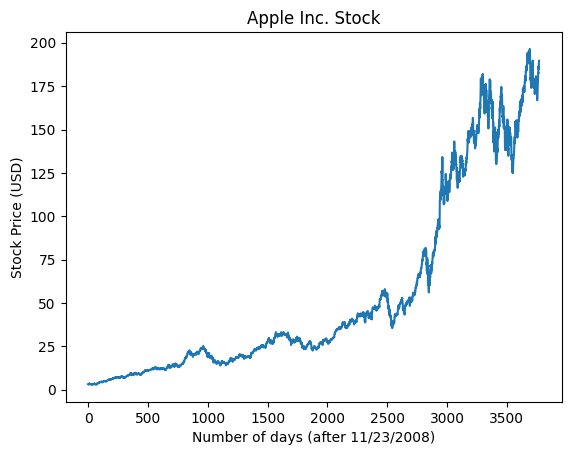

In [ ]:
plot_stock("AAPL")

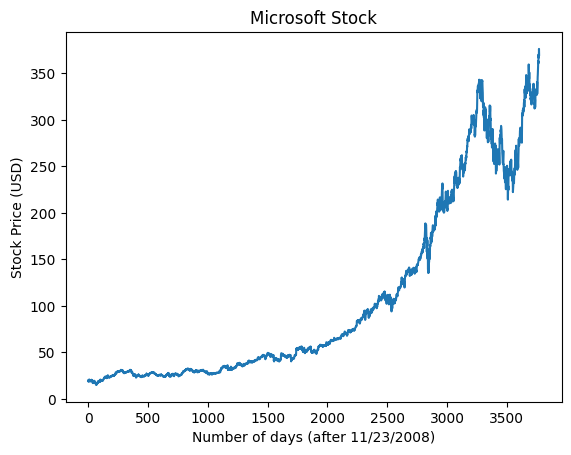

In [ ]:
plot_stock("MSFT")

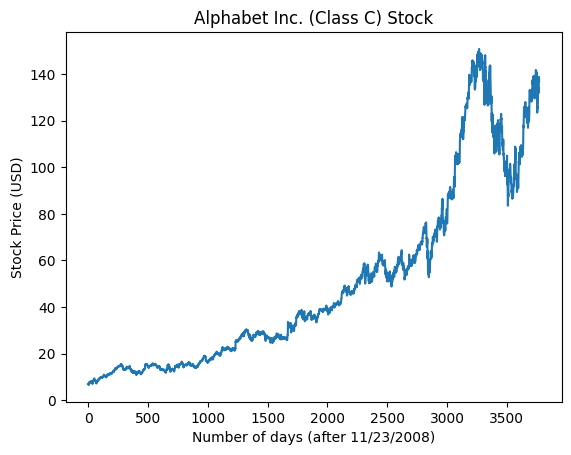

In [ ]:
plot_stock("GOOG")

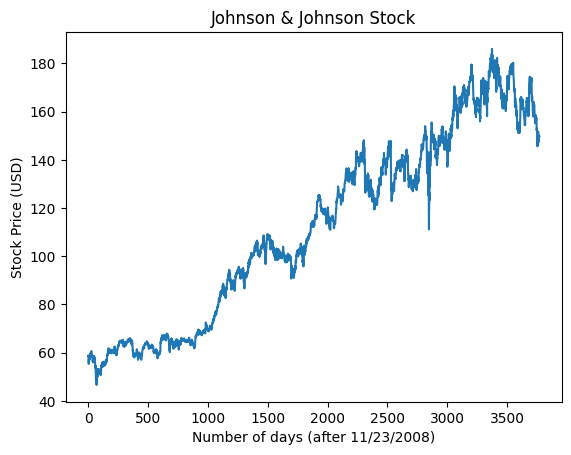

In [ ]:
plot_stock("JNJ")

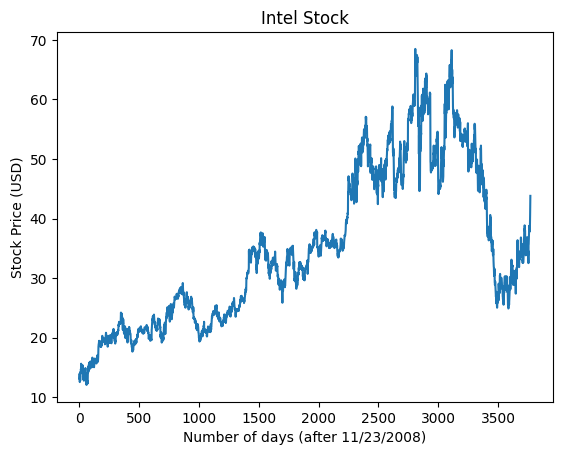

In [ ]:
plot_stock("INTC")

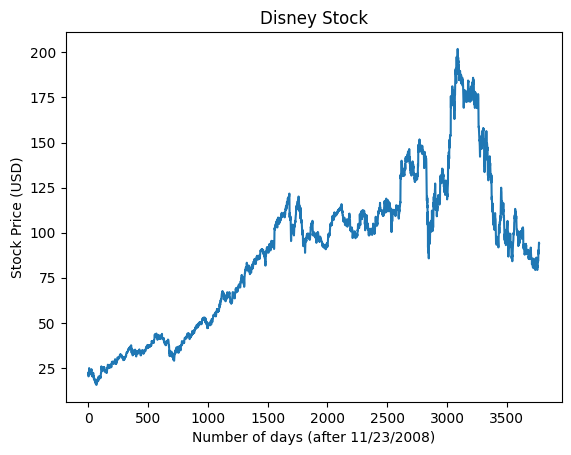

In [ ]:
plot_stock("DIS")

# Train Deep Q-Learning Model

In [ ]:
num_days_per_company = 30

In [ ]:
input_shape = num_days_per_company*len(companies)
print(input_shape)
output_shape = len(companies)
print(output_shape)

15060
502


In [ ]:
def make_model(layers=[100, 100, 100], # number of hidden layers and number of neurons for hidden layers
               input_shape=input_shape, # input shape of model
               output_shape=output_shape, # output shape of model
               learning_rate=0.001, # learning rate
               kernel_initializer=HeUniform, # kernel initializer
               hidden_activation='relu', # activation function for hidden layers
               output_activation='linear', # activation function for output layer
               loss=Huber,
               optimizer=Adam,
               metrics='accuracy'
              ):
  if not isinstance(metrics, list):
    metrics = [metrics]
  input_layer = Input(shape=input_shape)
  model = input_layer
  for layer in layers:
    model = Dense(units=layer, activation=hidden_activation, kernel_initializer=kernel_initializer())(model)
  model = Dense(output_shape, activation=output_activation, kernel_initializer=kernel_initializer())(model)
  model = Model(input_layer, model)
  model.compile(loss=loss(), optimizer=optimizer(learning_rate=learning_rate), metrics=metrics)
  return model

In [ ]:
make_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15060)]           0         
                                                                 
 dense (Dense)               (None, 100)               1506100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 502)               50702     
                                                                 
Total params: 1577002 (6.02 MB)
Trainable params: 1577002 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

x = []
y = []


In [ ]:

for i in range(num_days_per_company, len(companies[0].stock)):
  x_i = []
  y_i = []
  for j in range(len(companies)):
    x_i.extend(companies[j].stock[i-num_days_per_company:i])
    y_i.append(companies[j].stock[i])
  x.append(x_i)
  y.append(y_i)


In [ ]:

x = np.array(x)
y = np.array(y)


In [ ]:

print(x.shape)
print(y.shape)


(3741, 15060)
(3741, 502)


In [ ]:

np.save(drive_dir+"x.npy", x)
np.save(drive_dir+"y.npy", y)


In [ ]:
train_portion = 2.0/3.0
val_portion = 1.0/6.0
test_portion = 1.0/6.0

In [ ]:
train_idx = int(x.shape[0]*train_portion)
val_idx = int(x.shape[0]*val_portion)+train_idx
test_idx = x.shape[0]+1

In [ ]:

x_train = x[:train_idx]
x_val = x[train_idx:val_idx]
x_test = x[val_idx:test_idx]


In [ ]:

y_train = y[:train_idx]
y_val = y[train_idx:val_idx]
y_test = y[val_idx:test_idx]


In [ ]:

print(x_train.shape)
print(y_train.shape)


(2494, 15060)
(2494, 502)


In [ ]:

print(x_val.shape)
print(y_val.shape)


(623, 15060)
(623, 502)


In [ ]:

print(x_test.shape)
print(y_test.shape)


(624, 15060)
(624, 502)


In [ ]:

normalizer_x = Normalizer()
normalizer_y = Normalizer()


In [ ]:
"""
x_train = normalizer_x.fit_transform(x_train)
y_train = normalizer_y.fit_transform(y_train)

x_val = normalizer_x.transform(x_val)
y_val = normalizer_y.transform(y_val)

x_test = normalizer_x.transform(x_test)
y_test = normalizer_y.transform(y_test)
"""

'\nx_train = normalizer_x.fit_transform(x_train)\ny_train = normalizer_y.fit_transform(y_train)\n\nx_val = normalizer_x.transform(x_val)\ny_val = normalizer_y.transform(y_val)\n\nx_test = normalizer_x.transform(x_test)\ny_test = normalizer_y.transform(y_test)\n'

In [ ]:
"""
dump(normalizer_x, open(drive_dir+'normalizer_x.pkl', 'wb'))
dump(normalizer_y, open(drive_dir+'normalizer_y.pkl', 'wb'))
"""

"\ndump(normalizer_x, open(drive_dir+'normalizer_x.pkl', 'wb'))\ndump(normalizer_y, open(drive_dir+'normalizer_y.pkl', 'wb'))\n"

In [ ]:
"""
np.save(drive_dir+"x_train.npy", x_train)
np.save(drive_dir+"y_train.npy", y_train)

np.save(drive_dir+"x_val.npy", x_val)
np.save(drive_dir+"y_val.npy", y_val)

np.save(drive_dir+"x_test.npy", x_test)
np.save(drive_dir+"y_test.npy", y_test)
"""

'\nnp.save(drive_dir+"x_train.npy", x_train)\nnp.save(drive_dir+"y_train.npy", y_train)\n\nnp.save(drive_dir+"x_val.npy", x_val)\nnp.save(drive_dir+"y_val.npy", y_val)\n\nnp.save(drive_dir+"x_test.npy", x_test)\nnp.save(drive_dir+"y_test.npy", y_test)\n'

In [ ]:
def get_q_values(model, stock):
  return model.predict(np.array([stock]))[0]

In [ ]:
def train(replay_memory, model, target_model, end, lr=0.7, discount=0.618, min_replay_size=1000, batch_size=128):

    if len(replay_memory) < min_replay_size:
        return

    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, end) in enumerate(mini_batch):
        if not end:
            max_future_q = reward + discount * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - lr) * current_qs[action] + lr * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
def tanh(x):
  return (np.exp(2*x)-1)/(np.exp(2*x)+1)

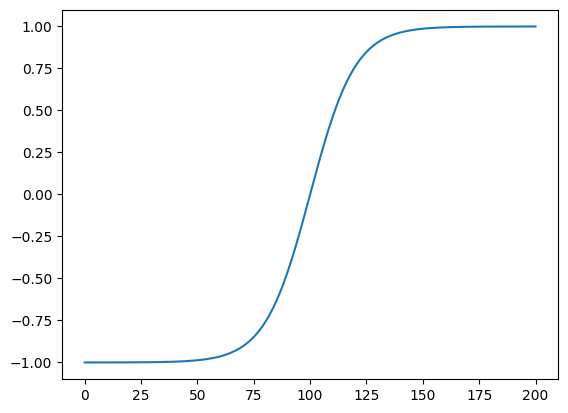

In [ ]:
plt.plot([tanh(0.05*i) for i in range(-100, 101)])

In [ ]:
def step(i, action, a=0.05):
  stock_price = x_train[i][num_days_per_company*action + num_days_per_company - 1]
  next_day_stock_price = y_train[i][action]
  diff = next_day_stock_price - stock_price
  percent_diff = diff/stock_price
  reward = tanh(a*percent_diff)
  done = False
  new_i = i+1
  if new_i >= x_train.shape[0]-1:
    done = True
  new_observation = x_train[new_i]
  return [new_i, new_observation, reward, done]

In [ ]:
def fit_model(
    layers=[100, 100, 100], # hidden layers for model
    train_episodes = 4,
    epsilon=1, # initial epsilon value
    max_epsilon=1, # maximum epsilon value
    min_epsilon=0.01, # minimum epsilon value
    decay = 0.01,
    update=4, # updates model every update steps
    target_update=100 # updates target_model every target_update steps
):

  model = make_model(layers=layers)
  target_model = make_model(layers=layers)
  target_model.set_weights(model.get_weights())

  replay_memory = deque(maxlen=50000)

  target_update_counter = 0

  X = []
  y = []

  steps = 0

  for episode in range(train_episodes):
      total_training_rewards = 0
      i = 0
      observation = x_train[i]
      done = False
      while not done:
          progress_bar = list('**********')
          for k in range(int(10*i/x_train.shape[0])):
            progress_bar[k] = '-'
          progress_bar = "".join(progress_bar)
          print(f"Episode {episode+1}/{train_episodes}: {i}/{x_train.shape[0]} {progress_bar[:5]}{round(100*i/x_train.shape[0], 2)}%{progress_bar[5:]}")
          steps += 1

          random_number = np.random.rand()
          if random_number <= epsilon:
              action = np.random.randint(len(companies))
          else:
              predicted = get_q_values(model, observation)
              action = np.argmax(predicted)
          new_i, new_observation, reward, done = step(i, action)
          replay_memory.append([observation, action, reward, new_observation, done])

          # 3. Update the Main Network using the Bellman Equation
          if steps % update == 0 or done:
              train(replay_memory, model, target_model, done)

          observation = new_observation
          i = new_i
          total_training_rewards += reward

          if done:
              print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
              total_training_rewards += 1

              if steps >= 100:
                  print('Copying main network weights to the target network weights')
                  target_model.set_weights(model.get_weights())
                  steps = 0
              break

      epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
  return model, target_model

In [ ]:
models = []

In [ ]:

for i in range(1, 2): # number of 100 neuron hidden layers for model
  model, target_model = fit_model(layers=[100 for k in range(i)])
  model.save(drive_dir+f"model")
  models.append(model)


Streaming output truncated to the last 5000 lines.
Episode 3/4: 1698/2494 -----68.08%-****
Episode 3/4: 1699/2494 -----68.12%-****
4/4 [==============================] - 0s 4ms/step
Episode 3/4: 1700/2494 -----68.16%-****
Episode 3/4: 1701/2494 -----68.2%-****
Episode 3/4: 1702/2494 -----68.24%-****
Episode 3/4: 1703/2494 -----68.28%-****
4/4 [==============================] - 0s 5ms/step
Episode 3/4: 1704/2494 -----68.32%-****
Episode 3/4: 1705/2494 -----68.36%-****
Episode 3/4: 1706/2494 -----68.4%-****
Episode 3/4: 1707/2494 -----68.44%-****
4/4 [==============================] - 0s 5ms/step
Episode 3/4: 1708/2494 -----68.48%-****
Episode 3/4: 1709/2494 -----68.52%-****
Episode 3/4: 1710/2494 -----68.56%-****
Episode 3/4: 1711/2494 -----68.6%-****
4/4 [==============================] - 0s 7ms/step
Episode 3/4: 1712/2494 -----68.64%-****
Episode 3/4: 1713/2494 -----68.68%-****
Episode 3/4: 1714/2494 -----68.72%-****
Episode 3/4: 1715/2494 -----68.77%-****
4/4 [=======================

# Load data and models

In [ ]:
normalizer_x = load(open(drive_dir+"normalizer_x.pkl", "rb"))
normalizer_y = load(open(drive_dir+"normalizer_y.pkl", "rb"))

In [ ]:
x = np.load(drive_dir+"x.npy")
y = np.load(drive_dir+"y.npy")

x_train = np.load(drive_dir+"x_train.npy")
y_train = np.load(drive_dir+"y_train.npy")

x_val = np.load(drive_dir+"x_val.npy")
y_val = np.load(drive_dir+"y_val.npy")

x_test = np.load(drive_dir+"x_test.npy")
y_test = np.load(drive_dir+"y_test.npy")

In [ ]:
models = []

In [ ]:
for i in range(1, 2):
  models.append(keras.models.load_model(drive_dir+f"model"))

# Test Deep Q-Learning Models on Validation Set

In [ ]:
def stock_growth(company, i, j):
  return companies[company].stock[j]/companies[company].stock[i]

In [ ]:
def invest(model, stocks):
  return np.argmax(model.predict(np.array([stocks]))[0])

In [ ]:
def get_balances(model, stocks_x, buffer_idx):
  balances = []
  balance = 1
  balances.append(balance)
  for i in range(stocks_x.shape[0]-1):
    balance *= stock_growth(invest(model, stocks_x[i]), i+buffer_idx+num_days_per_company, i+buffer_idx+num_days_per_company+1)
    balances.append(balance)
  return (balances, balance)

In [ ]:
balances = []
final_balances = []

In [ ]:
for i in range(len(models)):
  balances_i, final_balance_i = get_balances(models[i], x_val, train_idx)
  balances.append(balances_i)
  final_balances.append(final_balance_i)

1/1 [==============================] - 0s 29ms/step


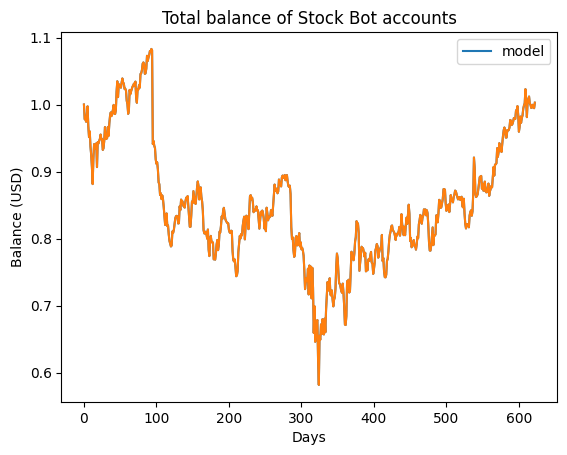

In [ ]:
for balance in balances:
  plt.plot(balance)
plt.title("Total balance of Stock Bot accounts")
plt.ylabel("Balance (USD)")
plt.xlabel("Days")
plt.legend([f"model" for i in range(len(models)-1)])
plt.show()

In [ ]:
print(f"Final balance for model: {final_balances[0]}")
print(f"Percent return over 623 days for model: {100*(final_balances[0]-1)}%")
print(f"Average daily percent return: {100*(final_balances[0]**(1/x_val.shape[0])-1)}%")
print(f"Average yearly percent return: {100*(final_balances[0]**(365/x_val.shape[0])-1)}%")

Final balance for model: 1.002763039459344
Percent return over 623 days for model: 0.27630394593440855%
Average daily percent return: 0.0004428949266221949%
Average yearly percent return: 0.16178702445353021%


In [ ]:
print(companies[invest(models[0], x_test[-1])].name) # company that the model recommends investing in today

1/1 [==============================] - 0s 27ms/step
3M
